# Risk Premia Harvesting - Periodic Deposits Strategy

## Overview

This notebook implements a dollar-cost averaging strategy with periodic monthly deposits to harvest risk premia from a diversified portfolio. Each month, a fixed dollar amount is invested in the same asset allocation without any rebalancing.

**Portfolio Composition:**
- SPY (S&P 500 ETF): 50%
- TLT (Long-term Treasury ETF): 35%
- GLD (Gold ETF): 15%

**Investment Strategy:**
- Monthly deposit: $100.00
- Allocation per deposit: $50 to SPY, $35 to TLT, $15 to GLD
- Investment timing: Start of each month
- No rebalancing or selling

**Investment Period:** Approximately 10 years

## Target Outputs

### Performance Metrics
- Annualized Return
- Annualized Volatility
- Sharpe Ratio
- Maximum Drawdown
- Total Amount Invested
- Final Portfolio Value

### Visualizations
- Equity curves (total portfolio and individual assets)
- Total capital invested over time
- 1-year rolling annualized return
- 1-year rolling annualized volatility
- 1-year rolling Sharpe ratio

## Implementation Steps

### 1. Data Acquisition
Load historical price data for SPY, TLT, and GLD

### 2. Data Preparation
   1. Remove rows with missing data
   2. Ensure all tickers share the same date index
   3. Identify first trading day of each month

### 3. Monthly Investment Logic
   1. Define monthly deposit amount ($100) and allocation ratios
   2. For each month's first trading day:
      - Calculate shares purchased for each asset based on that day's price
      - Track cumulative shares held for each asset

### 4. Equity Curve Construction
   1. Calculate daily equity for each asset (cumulative shares × daily price)
   2. Compute total portfolio equity
   3. Track cumulative capital invested over time
   4. Consolidate results into a unified DataFrame

### 5. Returns Calculation
   1. Compute portfolio daily returns
   2. Compute individual asset daily returns

### 6. Performance Statistics
   1. Calculate total capital invested
   2. Calculate annualized return
   3. Calculate annualized volatility
   4. Calculate Sharpe ratio
   5. Calculate maximum drawdown

### 7. Static Visualizations
   1. Plot all equity curves on a single chart
   2. Plot cumulative capital invested alongside portfolio value

### 8. Rolling Performance Analysis
   1. Generate rolling 1-year annualized return chart
   2. Generate rolling 1-year annualized volatility chart
   3. Generate rolling 1-year Sharpe ratio chart

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Acquisition

spy_returns = pd.read_csv("C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\data\\returns\\returns_SPY.csv", index_col=0, parse_dates=True)
tlt_returns = pd.read_csv("C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\data\\returns\\returns_TLT.csv", index_col=0, parse_dates=True)
gld_returns = pd.read_csv("C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\data\\returns\\returns_GLD.csv", index_col=0, parse_dates=True)

# 2. Data Preparation

# Combine all returns into a single DataFrame
close_df = pd.DataFrame({
    'SPY': spy_returns['Close'],
    'TLT': tlt_returns['Close'],
    'GLD': gld_returns['Close']
})

# Drop rows with any missing data
close_df = close_df.dropna()

# Identify month-start dates (first trading day of each month)
month_start_dates = close_df.resample('MS').first().index

# Create a boolean column to mark investment dates
close_df['is_first_trading_day'] = close_df.index.isin(month_start_dates)

In [2]:
# 3. Monthly Investment Logic

# Define monthly deposit amount and allocation ratios
monthly_deposit = 100.00
allocation_ratios = {
    'SPY': 0.50,  # $50 per month
    'TLT': 0.35,  # $35 per month
    'GLD': 0.15   # $15 per month
}

# Identify first trading day of each month
# Get the first available trading day for each month
month_start_dates = close_df.groupby(close_df.index.to_period('M')).apply(lambda x: x.index[0])

# Create a boolean column to mark monthly investment dates
close_df['is_investment_date'] = close_df.index.isin(month_start_dates)

# Initialize tracking for cumulative shares
cumulative_shares = {
    'SPY': 0.0,
    'TLT': 0.0,
    'GLD': 0.0
}

# Track shares purchased each month for transparency
monthly_purchases = []

# Iterate through each date to build cumulative shares
for date in close_df.index:
    # Check if this is an investment date (first trading day of the month)
    if close_df.loc[date, 'is_investment_date']:
        # Get current prices
        current_prices = close_df.loc[date, ['SPY', 'TLT', 'GLD']]
        
        # Calculate shares purchased for each asset based on that day's price
        shares_purchased = {
            'SPY': (monthly_deposit * allocation_ratios['SPY']) / current_prices['SPY'],
            'TLT': (monthly_deposit * allocation_ratios['TLT']) / current_prices['TLT'],
            'GLD': (monthly_deposit * allocation_ratios['GLD']) / current_prices['GLD']
        }
        
        # Track cumulative shares held for each asset
        cumulative_shares['SPY'] += shares_purchased['SPY']
        cumulative_shares['TLT'] += shares_purchased['TLT']
        cumulative_shares['GLD'] += shares_purchased['GLD']
        
        # Record the purchase for analysis
        monthly_purchases.append({
            'Date': date,
            'SPY_shares': shares_purchased['SPY'],
            'TLT_shares': shares_purchased['TLT'],
            'GLD_shares': shares_purchased['GLD'],
            'SPY_price': current_prices['SPY'],
            'TLT_price': current_prices['TLT'],
            'GLD_price': current_prices['GLD'],
            'SPY_cumulative': cumulative_shares['SPY'],
            'TLT_cumulative': cumulative_shares['TLT'],
            'GLD_cumulative': cumulative_shares['GLD']
        })

# Convert monthly purchases to DataFrame for analysis
purchases_df = pd.DataFrame(monthly_purchases)
purchases_df.set_index('Date', inplace=True)

# Display summary
print("=" * 50)
print("MONTHLY INVESTMENT SUMMARY")
print("=" * 50)
print(f"Monthly deposit: ${monthly_deposit:.2f}")
print(f"Allocation: SPY {allocation_ratios['SPY']:.0%}, TLT {allocation_ratios['TLT']:.0%}, GLD {allocation_ratios['GLD']:.0%}")
print(f"Number of monthly investments: {len(purchases_df)}")
print(f"Total capital invested: ${monthly_deposit * len(purchases_df):,.2f}")
print(f"\nFinal cumulative shares:")
print(f"  SPY: {cumulative_shares['SPY']:.4f} shares")
print(f"  TLT: {cumulative_shares['TLT']:.4f} shares")
print(f"  GLD: {cumulative_shares['GLD']:.4f} shares")

MONTHLY INVESTMENT SUMMARY
Monthly deposit: $100.00
Allocation: SPY 50%, TLT 35%, GLD 15%
Number of monthly investments: 131
Total capital invested: $13,100.00

Final cumulative shares:
  SPY: 23.0532 shares
  TLT: 45.2978 shares
  GLD: 13.1561 shares


In [3]:
# 4. Equity Curve Construction

# Initialize equity tracking
equity_data = []

# Track cumulative shares at each point in time
current_cumulative_shares = {
    'SPY': 0.0,
    'TLT': 0.0,
    'GLD': 0.0
}

# Track total capital invested
total_invested = 0.0

# Iterate through each date
for date in close_df.index:
    # Check if this is an investment date - update cumulative shares
    if close_df.loc[date, 'is_investment_date']:
        # Get current prices
        current_prices = close_df.loc[date, ['SPY', 'TLT', 'GLD']]
        
        # Calculate shares purchased for each asset
        shares_purchased = {
            'SPY': (monthly_deposit * allocation_ratios['SPY']) / current_prices['SPY'],
            'TLT': (monthly_deposit * allocation_ratios['TLT']) / current_prices['TLT'],
            'GLD': (monthly_deposit * allocation_ratios['GLD']) / current_prices['GLD']
        }
        
        # Update cumulative shares
        current_cumulative_shares['SPY'] += shares_purchased['SPY']
        current_cumulative_shares['TLT'] += shares_purchased['TLT']
        current_cumulative_shares['GLD'] += shares_purchased['GLD']
        
        # Update total invested
        total_invested += monthly_deposit
    
    # Get current prices for equity calculation
    current_prices = close_df.loc[date, ['SPY', 'TLT', 'GLD']]
    
    # Calculate daily equity for each asset (cumulative shares × daily price)
    spy_equity = current_cumulative_shares['SPY'] * current_prices['SPY']
    tlt_equity = current_cumulative_shares['TLT'] * current_prices['TLT']
    gld_equity = current_cumulative_shares['GLD'] * current_prices['GLD']
    
    # Compute total portfolio equity
    total_equity = spy_equity + tlt_equity + gld_equity
    
    # Store the equity values and cumulative capital invested
    equity_data.append({
        'Date': date,
        'SPY_equity': spy_equity,
        'TLT_equity': tlt_equity,
        'GLD_equity': gld_equity,
        'total_equity': total_equity,
        'capital_invested': total_invested
    })

# Consolidate results into a unified DataFrame
equity_df = pd.DataFrame(equity_data)
equity_df.set_index('Date', inplace=True)

# 5. Returns Calculation

# Compute portfolio daily returns
returns_df = pd.DataFrame(index=close_df.index)
returns_df['portfolio_return'] = equity_df['total_equity'].pct_change()

# Compute individual asset daily returns
returns_df['SPY_return'] = equity_df['SPY_equity'].pct_change()
returns_df['TLT_return'] = equity_df['TLT_equity'].pct_change()
returns_df['GLD_return'] = equity_df['GLD_equity'].pct_change()

# Drop the first row (NaN due to pct_change)
returns_df = returns_df.dropna()

# 6. Performance Statistics

# Assume 252 trading days per year
trading_days = 252

# Calculate annualized return
total_return = (equity_df['total_equity'].iloc[-1] / equity_df['total_equity'].iloc[0]) - 1
num_years = len(returns_df) / trading_days
annualized_return = (1 + total_return) ** (1 / num_years) - 1

# Calculate annualized volatility
annualized_volatility = returns_df['portfolio_return'].std() * np.sqrt(trading_days)

# Calculate Sharpe ratio (assuming 0% risk-free rate)
risk_free_rate = 0.0
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Calculate maximum drawdown
cumulative_returns = (1 + returns_df['portfolio_return']).cumprod()
running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - running_max) / running_max
max_drawdown = drawdown.min()

# Display equity curve summary
print("=" * 50)
print("EQUITY CURVE SUMMARY")
print("=" * 50)
print(f"Initial portfolio value: ${equity_df['total_equity'].iloc[0]:,.2f}")
print(f"Final portfolio value: ${equity_df['total_equity'].iloc[-1]:,.2f}")
print(f"Total return: ${equity_df['total_equity'].iloc[-1] - equity_df['total_equity'].iloc[0]:,.2f}")
print(f"Total return %: {((equity_df['total_equity'].iloc[-1] / equity_df['total_equity'].iloc[0]) - 1) * 100:.2f}%")
print("\n")

# Display results
print("=" * 50)
print("PORTFOLIO PERFORMANCE STATISTICS")
print("=" * 50)
print(f"Period: {equity_df.index[0].strftime('%Y-%m-%d')} to {equity_df.index[-1].strftime('%Y-%m-%d')}")
print(f"Number of years: {num_years:.2f}")
print(f"\nAnnualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

EQUITY CURVE SUMMARY
Initial portfolio value: $100.00
Final portfolio value: $24,234.80
Total return: $24,134.80
Total return %: 24134.80%


PORTFOLIO PERFORMANCE STATISTICS
Period: 2015-01-05 to 2025-11-19
Number of years: 10.86

Annualized Return: 65.81%
Annualized Volatility: 39.44%
Sharpe Ratio: 1.6686
Maximum Drawdown: -18.32%


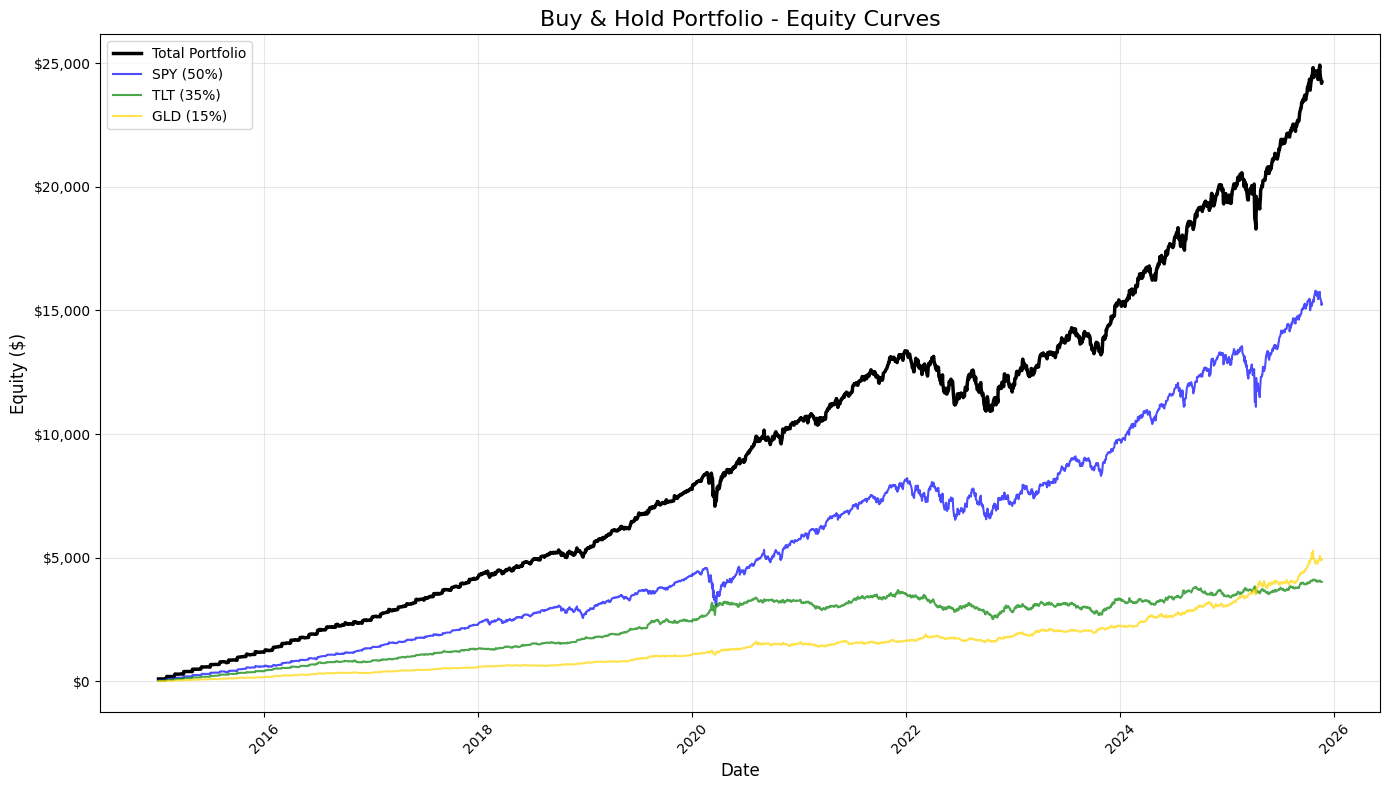

In [4]:
# 7. Static Visualizations

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot equity curves
ax.plot(equity_df.index, equity_df['total_equity'], label='Total Portfolio', linewidth=2.5, color='black')
ax.plot(equity_df.index, equity_df['SPY_equity'], label='SPY (50%)', linewidth=1.5, alpha=0.7, color='blue')
ax.plot(equity_df.index, equity_df['TLT_equity'], label='TLT (35%)', linewidth=1.5, alpha=0.7, color='green')
ax.plot(equity_df.index, equity_df['GLD_equity'], label='GLD (15%)', linewidth=1.5, alpha=0.7, color='gold')

# Formatting
ax.set_title('Buy & Hold Portfolio - Equity Curves', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Equity ($)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Format y-axis as currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

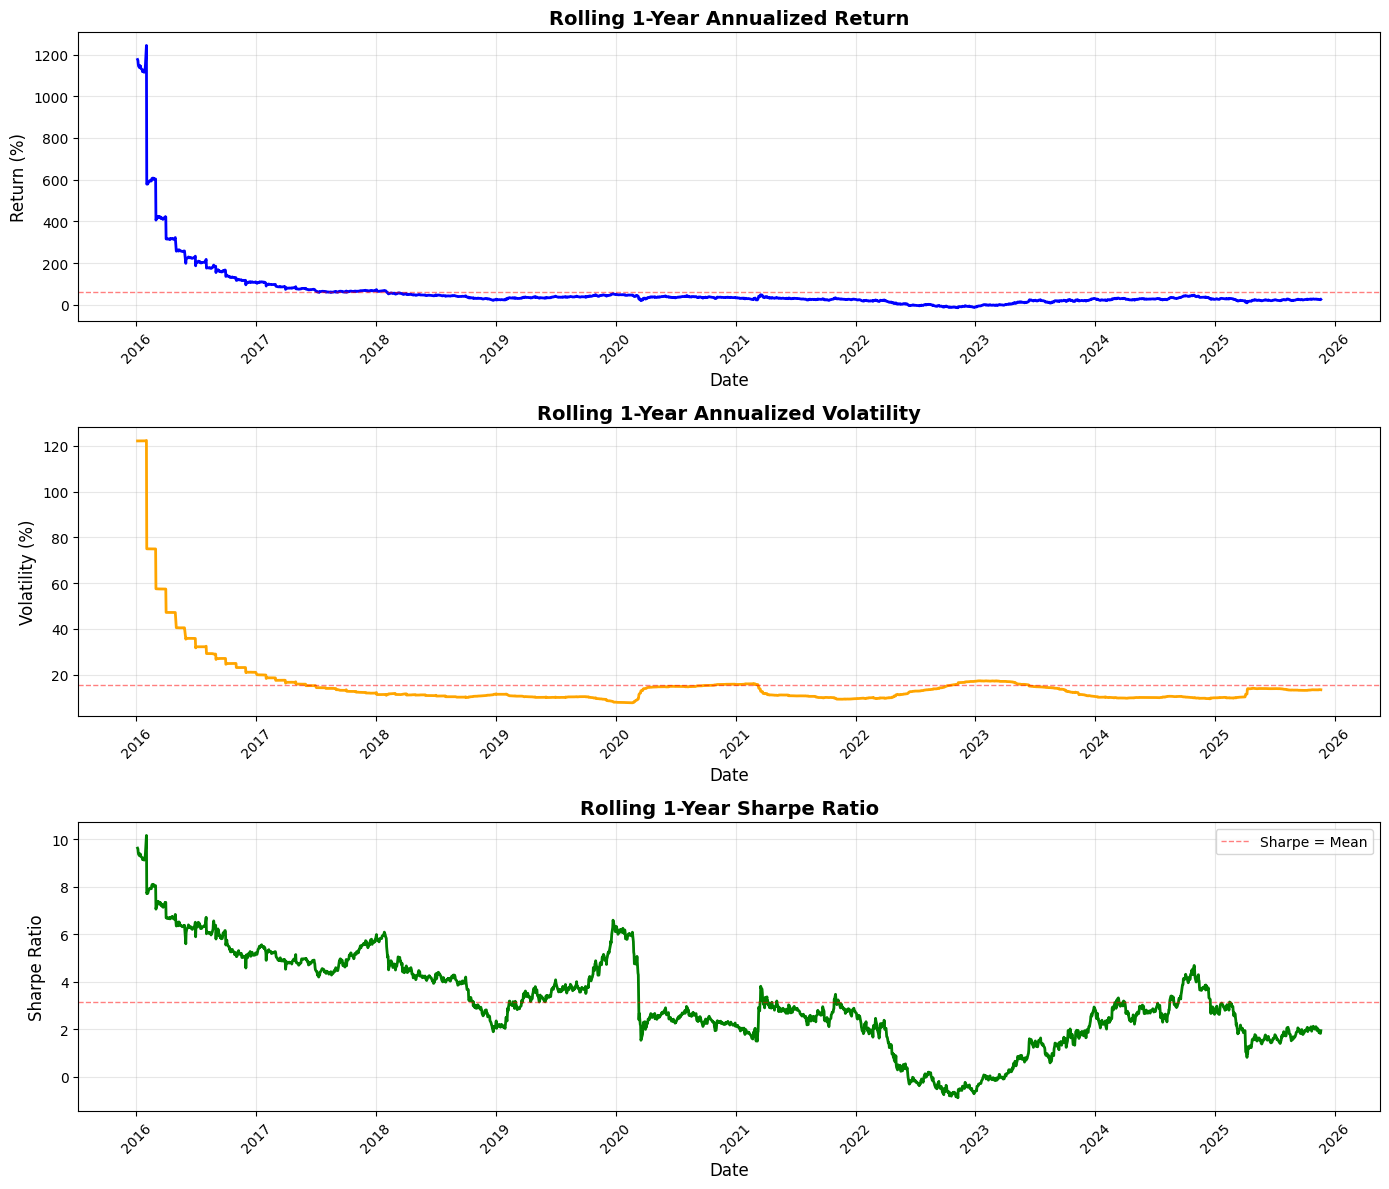


ROLLING METRICS SUMMARY (1-YEAR WINDOW)

Rolling Annualized Return:
  Mean: 61.12%
  Min:  -14.08%
  Max:  1243.40%

Rolling Annualized Volatility:
  Mean: 15.57%
  Min:  7.75%
  Max:  122.38%

Rolling Sharpe Ratio:
  Mean: 3.1401
  Min:  -0.8882
  Max:  10.1598


In [5]:
# 8. Rolling Performance Analysis

# Define rolling window (252 trading days = 1 year)
window = 252

# Calculate rolling metrics
rolling_return = returns_df['portfolio_return'].rolling(window=window).apply(
    lambda x: (1 + x).prod() ** (252 / len(x)) - 1
)

rolling_volatility = returns_df['portfolio_return'].rolling(window=window).std() * np.sqrt(252)

rolling_sharpe = rolling_return / rolling_volatility

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1. Rolling 1-Year Annualized Return
axes[0].plot(rolling_return.index, rolling_return * 100, linewidth=2, color='blue')
axes[0].axhline(y=rolling_return.mean() * 100, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Return = Mean')
axes[0].set_title('Rolling 1-Year Annualized Return', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Return (%)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel('Date', fontsize=12)

# 2. Rolling 1-Year Annualized Volatility
axes[1].plot(rolling_volatility.index, rolling_volatility * 100, linewidth=2, color='orange')
axes[1].axhline(y=rolling_volatility.mean() * 100, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Volatility = Mean')
axes[1].set_title('Rolling 1-Year Annualized Volatility', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volatility (%)', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlabel('Date', fontsize=12)

# 3. Rolling 1-Year Sharpe Ratio
axes[2].plot(rolling_sharpe.index, rolling_sharpe, linewidth=2, color='green')
axes[2].axhline(y=rolling_sharpe.mean(), color='red', linestyle='--', linewidth=1, alpha=0.5, label='Sharpe = Mean')
axes[2].set_title('Rolling 1-Year Sharpe Ratio', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Sharpe Ratio', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].legend(loc='best', fontsize=10)

# Format x-axis for all subplots
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics for rolling metrics
print("\n" + "=" * 50)
print("ROLLING METRICS SUMMARY (1-YEAR WINDOW)")
print("=" * 50)
print("\nRolling Annualized Return:")
print(f"  Mean: {rolling_return.mean():.2%}")
print(f"  Min:  {rolling_return.min():.2%}")
print(f"  Max:  {rolling_return.max():.2%}")

print("\nRolling Annualized Volatility:")
print(f"  Mean: {rolling_volatility.mean():.2%}")
print(f"  Min:  {rolling_volatility.min():.2%}")
print(f"  Max:  {rolling_volatility.max():.2%}")

print("\nRolling Sharpe Ratio:")
print(f"  Mean: {rolling_sharpe.mean():.4f}")
print(f"  Min:  {rolling_sharpe.min():.4f}")
print(f"  Max:  {rolling_sharpe.max():.4f}")
print("=" * 50)